In [ ]:
import numpy as np
import pandas as pd
import math
from datetime import datetime
import matplotlib.pyplot as plt

### Load Justice-centered data into pandas df

In [ ]:
# trainX = pd.read_csv('../data/trainX_justice.csv')
# trainY = pd.read_csv('../data/trainY_justice.csv')
# testX = pd.read_csv('../data/testX_justice.csv')
# testY = pd.read_csv('../data/testY_justice.csv')

We use the "Full" dataset to reduce the likelihood of predicting on an unseen justice

In [3]:
trainX = pd.read_csv('../data/trainX_justice_full.csv')
trainY = pd.read_csv('../data/trainY_justice_full.csv')

p = 0.1 # Proportion to shift to test set
cases = np.unique(trainX['caseId']) # list of all the cases (randomly select to choose as test)
num_test = int(np.floor(cases.shape[0] * p))

In [4]:
indices = np.random.randint(0, cases.shape[0], num_test)
mask = np.ones_like(cases,dtype=np.bool)
mask[indices] = 0 
test_cases = cases[indices]
train_cases = cases[mask]
train_idx = trainX.loc[trainX['caseId'].isin(train_cases)].index
test_idx = trainX.loc[trainX['caseId'].isin(test_cases)].index
tmpX = trainX
tmpY = trainY
testX = tmpX.loc[test_idx, :].copy().reset_index()
testY = tmpY.loc[test_idx, :].copy().reset_index()
trainX = tmpX.loc[train_idx, :].copy().reset_index()
trainY = tmpY.loc[train_idx, :].copy().reset_index()
tmpX = tmpY = -1

### Variables (from preprocessing)

In [5]:
# column names by category
id_variables_to_drop = [
    u'justiceName', #Name and unique ID
    ]
id_variables_to_keep = [
    u'justice',  #Name and unique ID
    u'caseId', u'docketId', u'caseIssuesId', u'voteId',
    u'usCite', u'sctCite', u'ledCite', u'lexisCite',
    u'docket']
    
bg_variables = [
    u'caseName', u'petitioner', u'petitionerState',
    u'respondent', u'respondentState', u'jurisdiction',
    u'adminAction', u'adminActionState', u'threeJudgeFdc',
    u'caseOrigin', u'caseOriginState', u'caseSource',
    u'caseSourceState', u'lcDisagreement', u'certReason',
    u'lcDisposition', u'lcDispositionDirection',
]

chrono_include = [u'naturalCourt', u'chief']
chrono_donotinclude = [u'dateDecision', u'decisionType', u'term',
                       u'dateArgument', u'dateRearg']
chrono_variables = chrono_include + chrono_donotinclude

substantive_variables = [
    u'issue', u'issueArea', u'decisionDirection',
    u'decisionDirectionDissent', u'authorityDecision1',
    u'authorityDecision2', u'lawType', u'lawSupp', u'lawMinor']

outcome_variables = [
    u'declarationUncon', u'caseDisposition',
    u'caseDispositionUnusual', u'partyWinning', u'precedentAlteration',  
    u'firstAgreement', u'secondAgreement']

voting_variables = [u'voteUnclear', u'majOpinWriter', u'majOpinAssigner',
                    u'splitVote', u'majVotes', u'minVotes',  u'vote', u'opinion',
                    u'direction', u'majority']


## Decide on outcome vector

## One-hot encode select categorical variables
#### + impute nulls

In [46]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.sparse import csr_matrix, hstack

class Categorical(object):
    def __init__(self, df, outcomes, ohe_threshold = 0.08):
        self.names = df['justiceName']
        #Drop name vector (redundant)
        self.arr = (df[id_variables_to_keep + bg_variables + chrono_include + substantive_variables]).copy()
        self.arr = self.arr.fillna(-1) # Impute values
        self.outcomes = outcomes.copy()
        self.outcomes = self.outcomes.fillna(-1) #Impute values
        # Select the categorical features to OHE
        ohe_vars = []
        other_vars = []
        print "Columns"
        print len(self.arr.columns)
        ohe_threshold = math.floor(ohe_threshold * self.arr.shape[0])
        for c in self.arr.columns:
            u =  len(self.arr[c].unique())
            if u < ohe_threshold:
#                 prZint "{0}: {1} unique".format(c, len(self.arr[c].unique()))
                ohe_vars.append(c)
            else:
                other_vars.append(c)
        print len(ohe_vars)
        print len(other_vars)
        self.n_samples, self.n_features = self.arr.shape
        self.n_cat_features = len(ohe_vars)
        self.ohe_vars = ohe_vars
        self.other_vars = other_vars
        self.cont_vars = []
        self.arr = pd.concat([self.arr[other_vars], self.arr[ohe_vars]], axis=1)
        self.columns = other_vars + ohe_vars
        
        
        #Label Encode select categorical variables
        self.LE()
        self.other = self.arr[other_vars].copy() #ID and other features
        self.cat = self.arr[ohe_vars].copy() #Categorical features
        self.cat_ohe = self.cat.copy() #OHE categorical features
        self.n_justices = len(self.cat['justice'].unique())
        #Label Encode the outcome variables
        self.LE_Outcomes()
        #OHE the categorical data
        self.OHE()
        
        
    def LE(self):
        '''Label Encode ALL variables (to give reasonable feautures) '''  
        le = {}  #keep le global so we may inverse_transform if necessary
        for c in self.columns: #self.ohe_vars: #text_cols:
            le[c] = LabelEncoder()
            self.arr.loc[:,c] = le[c].fit_transform(self.arr[c])
        self.le = le # label encoder (useful for reverse transforming also)
        
    def LE_Outcomes(self):
        le = {}
        for c in self.outcomes.columns:
            le[c] = LabelEncoder()
            self.outcomes.loc[:,c] = le[c].fit_transform(self.outcomes[c])
                
        self.le_out = le
        
    def OHE(self):
        self.ohe = OneHotEncoder()
        self.ohe.fit(self.cat)
        self.cat_ohe =  self.ohe.transform(self.cat) 
    
    
    def orig_cat(self): # Not important since I cache the values, but keep for possible future functions
        '''Returns the original array of the OHE encoded csr array
            (requires the original one-hot encoder fit to the dataset) '''
        return np.array([self.ohe.active_features_[col] for col in 
                            self.cat.sorted_indices().indices]).reshape(self.n_samples, self.n_cat_features) \
                                - self.ohe.feature_indices_[:-1]
        
    def getValue(self, col):
        '''Return the original value for the label-encoded variable'''
        if col not in self.columns:#self.ohe_vars:
            return None
        le = self.le[self.columns.index(col)]
        return le.inverse_transform(self.cat[col])

    def isolate_justice(self, ID, deep=False, ind=True):
        '''Return sparse array for data for a single justice '''
        
        #Check if ID is a legal label-encodded justice id
        if ID < 0 or ID >= self.n_justices:
            print "Error: Not a legal justice ID"
            return None
        
        if ind:
            return self.cat.loc[self.cat['justice'] == ID].index
        elif deep:
            return self.cat.loc[self.cat['justice'] == ID].copy()
        else:
            return self.cat.loc[self.cat['justice'] == ID]
        
    def merge_Xmatrices(self, rows):
        return hstack((csr_matrix(self.other.values[rows,:]), self.cat_ohe[rows,:]))
    
    
    def justice_X(self, ID):
        return self.merge_Xmatrices(rows=self.isolate_justice(ID))
    
    def justice_Y(self, ID):
        return self.outcomes.values[self.isolate_justice(ID), :]
    def add_feature(self, name, d, categorical=True):
        '''Takes as input a dictionary of (justiceId: value) pairs. '''
        typ = type(d.values()[0]) # Try to guess dtype (not really necessary in this sandbox, but hey)
        col = np.zeros(self.arr.shape[0], dtype=typ)
        for j, val in d.items():
            indices = self.isolate_justice(j)
            col[indices] = val
        if name in self.le:
            print "Header Name already in use. Aborting."
            return None
        if categorical:
            self.le[name] = LabelEncoder()
            col = self.le[name].fit_transform(col)
        
        #Append to arr, cat
        col = pd.DataFrame({name: col})
        self.columns.append(name)
        self.arr = pd.concat((self.arr, col), axis=1)
        if categorical:
            self.cat = pd.concat((self.cat, col), axis=1)
            self.OHE() # Must re-OHE (Not too expensive in general)
        else: # Continuous
            self.cont_vars.append(name) #Only index continuous variables
            self.other = pd.concat((self.other, col), axis=1)
    def feature_array(self):
        return np.concatenate((self.other[self.cont_vars], self.cat_ohe.toarray()), axis=1)
    def label_array(self):
        return self.outcomes['direction']
        
def index_outcome(arr, col, columns):
    return arr[:, list(columns).index(col)]
        

## Create a categorical object

In [47]:
trainX_Cat = Categorical(df = trainX, outcomes = trainY)
testX_Cat = Categorical(df = testX, outcomes = testY)
trainX_names = np.unique(trainX['justiceName'])
testX_names = np.unique(testX['justiceName'])

Columns
38
28
10
Columns
38
28
10


In [49]:
print testX.shape
print trainX.shape
print trainX_Cat.cat_ohe.shape
print testX_Cat.cat_ohe.shape

(7415, 40)
(70674, 40)
(70674, 2534)
(7415, 1320)


## Cluster justices into 2 groups based on likelihood to side with majority

JHarlan2:	12
SDOConnor:	25

Green (relatively more frequently side with majority):
JHarlan2 WHRehnquist WEBurger WBRutledge TMarshall TCClark SSotomayor SMinton SGBreyer SFReed SAAlito RHJackson RBGinsburg PStewart JPStevens WJBrennan WODouglas HLBlack AJGoldberg DHSouter JGRoberts EWarren FFrankfurter EKagan HABlackmun FMVinson 

Blue (relatively more likely to vote minority):
SDOConnor FMurphy LFPowell CThomas CEWhittaker BRWhite AScalia AMKennedy HHBurton AFortas

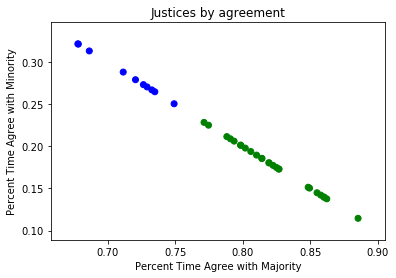

 JHarlan2:	12
TMarshall:	19

Green (relatively more frequently side with majority):
JHarlan2 SAAlito RHJackson RBGinsburg PStewart SMinton JPStevens SSotomayor JGRoberts HLBlack HHBurton TCClark SFReed FMVinson FFrankfurter EWarren EKagan DHSouter CThomas WBRutledge BRWhite WEBurger WHRehnquist AJGoldberg SGBreyer 

Blue (relatively more likely to vote minority):
TMarshall AFortas LFPowell WJBrennan HABlackmun FMurphy CEWhittaker AScalia AMKennedy SDOConnor WODouglas

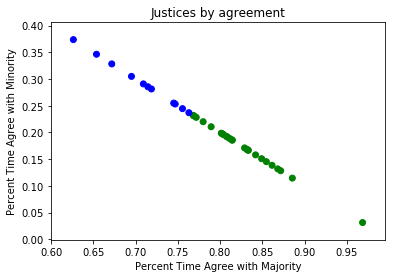

In [33]:
from sklearn.cluster import KMeans

#Toggle Values
col_title = "majMin"
display = True

# Create a dictionary to easily get name
name_to_id = { name: l for (name, l) in zip(trainX_Cat.names.unique(), trainX_Cat.arr['justice'].unique())}
id_to_name = { l: name for (name, l) in zip(trainX_Cat.names.unique(), trainX_Cat.arr['justice'].unique())}
#Same for test case
name_to_id_test = { name: l for (name, l) in zip(testX_Cat.names.unique(), testX_Cat.arr['justice'].unique())}
id_to_name_test = { l: name for (name, l) in zip(testX_Cat.names.unique(), testX_Cat.arr['justice'].unique())}

def maj_min_norm(cat, justiceID):
    '''Return 2D vector representation where dim_0 is the percent time 
        voting with majority and dim_1 is percent voting with minority'''
    j = cat.justice_Y(justiceID)
    maj_min = index_outcome(j,'majority', trainY.columns)
#     print np.unique(maj_min)
    n = maj_min.shape[0]
    total = np.sum(maj_min == 2)
    return [float(total)/n, float(n-total)/n]
    
def majMin_cluster(df, name_to_id, id_to_name, names, test=True):
    justices = np.array([maj_min_norm(df, i) for i in np.unique(df.arr['justice'].values)])

    kmeans = KMeans(n_clusters=2, init=np.array([[1, 0],[0, 1]]),n_init=1,  random_state=0).fit(justices)
    colors = np.where(kmeans.labels_ == 1, 'b', 'g')
    # Group by 
    groups = np.array([[n, 1] if c else [n, 0] for (c, n) in zip(kmeans.labels_ == 1,names)])
    groups =  groups[groups[:, 1].argsort()]

    n_0 = np.sum(groups[:, 1] == '0')
    n_1 = np.sum(groups[:, 1] == '1')
    minor = np.empty((n_0, 2), dtype=('string', float))
    major = np.empty((n_1, 2), dtype=('string', float))

    # Label-> Justice
    l_to_j = {}
    for i in range(groups.shape[0]):
        j = int(groups[i, 1]) 
        if j in l_to_j:
            l_to_j[j].append(name_to_id[groups[i, 0]])
        else:
            print "{0}:\t{1}".format(groups[i, 0], name_to_id[groups[i, 0]])
            l_to_j[j] = [name_to_id[groups[i, 0]]]

    print "\nGreen (relatively more frequently side with majority):"
    for name in l_to_j[0]:
        print id_to_name[name],
    print "\n\nBlue (relatively more likely to vote minority):"
    for name in l_to_j[1]:
        print id_to_name[name],

    j_to_l = {} #Justice -> Label dict
    for key, val in l_to_j.items():
        for j in val:
            j_to_l[j] = key
    if col_title not in df.arr.columns and not test:
        df.add_feature(col_title, j_to_l) # Add a "likely to vote with minority" variable

    # Plot results
    plt.scatter(justices[:, 0], justices[:, 1], c=colors)
    plt.title('Justices by agreement')
    plt.xlabel('Percent Time Agree with Majority')
    plt.ylabel('Percent Time Agree with Minority')
    plt.show()
    return col_title, j_to_l
    
col_title, j_to_l = majMin_cluster(trainX_Cat, name_to_id, id_to_name, trainX_names, test=False)
majMin_cluster(testX_Cat, name_to_id_test, id_to_name_test, testX_names)
#Need to do it this way to not cheat..
testX_Cat.add_feature(col_title, j_to_l)

In [45]:
print trainX_Cat.cat_ohe.shape
print testX_Cat.cat_ohe.shape

(70674, 2540)
(7415, 1326)


#### Note in the figure above that there are not distinct voting "Clusters", but it does seem that one may linearly separate the valuest

Question: Does it make sense that I am normalizing based on the total number of votes taken by a justice? Or should I normalize based on the total maj/min votes OVERALL?

## Now cluster based on Political inclination in each "issue" area

Cluster based on issues?

In [34]:
col_title = "idealogy"
def ideology_vector(cat, justiceID, vecSize):
    j_y = cat.justice_Y(justiceID)
    j_ind = cat.isolate_justice(justiceID)
    bias = index_outcome(j_y, 'direction', trainY.columns) # normalized lean (conservative | liberal) in this case
    issue = np.array((cat.cat['issueArea'].values)[j_ind]) # IssueArea for the case
    bias[np.where(bias == 2)] = -1 # Recode s.t. -1 ~ liberal, 0, nan, 1 ~ conservative
    v = np.zeros(vecSize, dtype=float)
    t = np.zeros(vecSize, dtype=float)
    # Sum the total values
    for i in range(bias.shape[0]):
        v[issue[i]] = v[issue[i]] + bias[i]
        t[issue[i]] = t[issue[i]] + 1

    for i in range(vecSize):
        if t[i] > 0:
            v[i] = v[i] / t[i] # normalize by totals for each subject area
    return v # v is then an "ideology vector" we may use to cluster justices


n_areas = trainX_Cat.le['issueArea'].classes_.shape[0] #Total general issue areas
x, y = np.unique(trainX_Cat.arr['justice'].values, return_index=True)
j_ids = np.array(sorted([ [x, y] for (x, y) in zip(x,y)], key=lambda l: l[1]))[:, 0]
# names = trainX_Cat.le['justiceName'].inverse_tranform(j_ids)
justices = np.array([ideology_vector(trainX_Cat, i, n_areas) for i in j_ids])  

#Add the continuous "ideology" vectors to the things
norm_justices = justices
for i in range(n_areas):
    idealogy = {}
    for j in j_ids:
        idealogy[j] = justices[i]
    c = "%s%s%s" % (col_title, "d", i)
    trainX_Cat.add_feature(c, idealogy, categorical=False)
    testX_Cat.add_feature(c, idealogy, categorical=False)

#Add the idealogy vectors in

x, y =  np.unique(testX_Cat.arr['justice'].values, return_index=True)
j_ids = np.array(sorted([ [x, y] for (x, y) in zip(x,y)], key=lambda l: l[1]))[:, 0]
justices_test = np.array([ideology_vector(testX_Cat, i, n_areas) for i in j_ids])  

# j_with_names = {id_to_name[l]: vec for (l, vec) in zip(j_ids, justices)}
    

/home/whinthorn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:114: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


In [35]:
print trainX_Cat.other.columns
print testX_Cat.other.columns

Index([u'caseId', u'docketId', u'caseIssuesId', u'voteId', u'usCite',
       u'sctCite', u'ledCite', u'lexisCite', u'docket', u'caseName',
       u'idealogyd0', u'idealogyd1', u'idealogyd2', u'idealogyd3',
       u'idealogyd4', u'idealogyd5', u'idealogyd6', u'idealogyd7',
       u'idealogyd8', u'idealogyd9', u'idealogyd10', u'idealogyd11',
       u'idealogyd12', u'idealogyd13', u'idealogyd14'],
      dtype='object')
Index([u'caseId', u'docketId', u'caseIssuesId', u'voteId', u'usCite',
       u'sctCite', u'ledCite', u'lexisCite', u'docket', u'caseName',
       u'idealogyd0', u'idealogyd1', u'idealogyd2', u'idealogyd3',
       u'idealogyd4', u'idealogyd5', u'idealogyd6', u'idealogyd7',
       u'idealogyd8', u'idealogyd9', u'idealogyd10', u'idealogyd11',
       u'idealogyd12', u'idealogyd13', u'idealogyd14'],
      dtype='object')


## Create 4 clusters 

In [36]:
print trainX_names
print testX_names

['AFortas' 'AJGoldberg' 'AMKennedy' 'AScalia' 'BRWhite' 'CEWhittaker'
 'CThomas' 'DHSouter' 'EKagan' 'EWarren' 'FFrankfurter' 'FMVinson'
 'FMurphy' 'HABlackmun' 'HHBurton' 'HLBlack' 'JGRoberts' 'JHarlan2'
 'JPStevens' 'LFPowell' 'PStewart' 'RBGinsburg' 'RHJackson' 'SAAlito'
 'SDOConnor' 'SFReed' 'SGBreyer' 'SMinton' 'SSotomayor' 'TCClark'
 'TMarshall' 'WBRutledge' 'WEBurger' 'WHRehnquist' 'WJBrennan' 'WODouglas']
['AFortas' 'AJGoldberg' 'AMKennedy' 'AScalia' 'BRWhite' 'CEWhittaker'
 'CThomas' 'DHSouter' 'EKagan' 'EWarren' 'FFrankfurter' 'FMVinson'
 'FMurphy' 'HABlackmun' 'HHBurton' 'HLBlack' 'JGRoberts' 'JHarlan2'
 'JPStevens' 'LFPowell' 'PStewart' 'RBGinsburg' 'RHJackson' 'SAAlito'
 'SDOConnor' 'SFReed' 'SGBreyer' 'SMinton' 'SSotomayor' 'TCClark'
 'TMarshall' 'WBRutledge' 'WEBurger' 'WHRehnquist' 'WJBrennan' 'WODouglas']


In [37]:
#The center-of-mass for the KMeans on the training dataset
inVec = np.array([[ -0.0244026806527, -0.0558264238058, -0.156417287945, -0.10066429494,
          -0.323551771618, -0.069625587029, -0.469631185808, -0.0907648163676, 
          -0.029025230359, 0.189929474252, -0.177569697334, 0.0, 
          -0.365343893194, -0.0555555555556, 0.0],
        [ -0.0133333333333, 0.401859299291, 0.203832291671, 0.261568177981,
         0.00348673717842, 0.67353353677, 0.233316362621, 0.141628144099,
         0.00683037700267, 0.341179056921, -0.0814992234008, 0.0,
         -0.392486004103, 0.0327272727273, 0.0],
        [ 0.0, -0.59649122807, -0.521739130435, -0.233333333333, -0.5, 
         1.0, 0.0, -0.5, -0.674418604651, 
         -0.216216216216, -0.15, 0.0, -0.777777777778, 0.0, 0.0],
        [ -0.0330782312925, -0.561335380182, -0.663705854674, -0.653772178576, 
         -0.634776987879, -0.333354629866, -0.633753229974, -0.31285542346, 
         -0.474041195724, 0.111838370646, -0.321520788452, 0.0, -0.342243821897, 0.0, 0.0]])



def idealogy_labels(justices):
    km = KMeans(n_clusters=4, init=inVec, n_init= 1, random_state=0).fit(justices)
#     km = KMeans(n_clusters=4, random_state=0).fit(justices)

    # colors = np.where(kmeans.labels_ == 1, 'b', 'g')
    labels = km.labels_
    n = labels.shape
    colors = np.empty(n, dtype=str)
    for i in range(n[0]): 
        if labels[i] == 0:
            colors[i] = 'g'
        elif labels[i] == 1:
            colors[i] = 'b'
        elif labels[i] == 2:
            colors[i] = 'r'
        else:
            colors[i] = 'm'
    return colors, labels

colors, labels = idealogy_labels(justices)
colors_test, labels_test = idealogy_labels(justices_test)

## Project onto top 2 principal components

(36, 15)


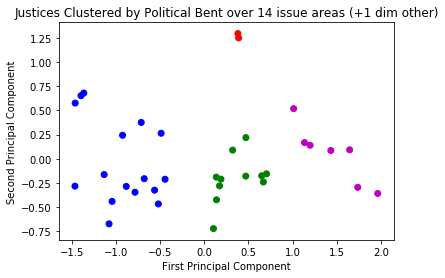

Adding bias
(36, 15)


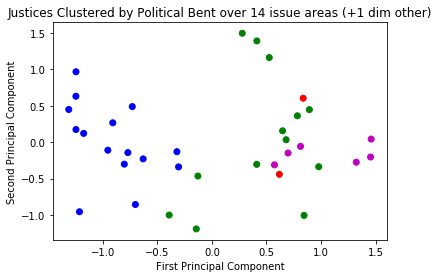

In [38]:
from sklearn.decomposition import PCA
#Toggle Values
col_title = "bias"
display = False
def idealogy_cluster(df, justices, colors, labels, names, name_to_id, id_to_name, test=True):
    pca = PCA()
    print justices.shape
    pca.fit(justices)
    justices_pca = pca.transform(justices)
    plt.scatter(justices_pca[:,0], justices_pca[:, 1], c=colors)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('Justices Clustered by Political Bent over 14 issue areas (+1 dim other)')
    plt.show()
    #Print out labels
    vals = sorted(zip(names, justices_pca, labels), key= lambda x: x[2])
    if display:
        print "Justices sorted by label type (based on political inclination)"
    #create a label: justice dictionary 
    groups = {}
    for name, val, l in vals:
        if l in groups:
            groups[l].append(name_to_id[name])
        else:
            groups[l] = []
            groups[l].append(name_to_id[name])
        if display:
            print "Justice {0: <12}:\t{1: 0.2f},\t{2:.2f}\tLabel {3}".format(name, val[0], val[1], l)
    # Create a justice: label dictionary
    bias = {}
    for key, val in groups.items():
        for j in val:
            bias[j] = key    
    if col_title not in df.arr.columns and not test:
        print "Adding {0}".format(col_title)
        df.add_feature(col_title, bias)
    return col_title, bias
col_title, bias = idealogy_cluster(trainX_Cat, justices, colors, labels, trainX_names, name_to_id, id_to_name, test=False)
idealogy_cluster(testX_Cat, justices_test, colors_test, 
                 labels_test, testX_names, name_to_id_test, id_to_name_test)
if col_title not in testX_Cat.arr.columns:
    testX_Cat.add_feature(col_title, bias)

## Time to Predict!

In [39]:
from sklearn.linear_model import RandomizedLasso, RandomizedLogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [40]:
# #Doesn't work..
# rlasso = RandomizedLasso(sample_fraction=0.5, verbose=True)
# rlasso.fit(testX_Cat.feature_array(), testX_Cat.label_array())
# print rlasso.scores_

In [41]:
# print np.sum(rlasso.scores_)
# print len(rlasso.scores_)
# for i in range(len(rlasso.scores_)):
#     if rlasso.scores_[i] > 0:
#         print i

In [42]:
rfc = RandomForestClassifier(verbose=True, n_estimators=100,n_jobs=-1 )
rfc = rfc.fit(trainX_Cat.feature_array(), trainX_Cat.label_array())

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   55.3s finished


In [43]:
print testX_Cat.feature_array().shape
print trainX_Cat.feature_array().shape

(7415, 1341)
(70674, 2555)


In [44]:
rfc.score(testX_Cat.feature_array(), testX_Cat.label_array())

ValueError: Number of features of the model must match the input. Model n_features is 2555 and input n_features is 1341 

## Working Outline

* In progress...

The lack of data would indicate that an rnn may not be a particularly appropriate model for this task; however it would be fun to try in order to see how the sequence of issues or the long-term trends of a justice come into play for future decisions. 

### Workflow:

#### Data Preparation:

Impute values -> maybe categorize nan's as -1, etc. (There are no negative values here)

OHE categorical variables

Drop the justiceName column -> all information is in 'justice'


#### RNN